In [1]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally
fix_pythonpath_if_working_locally()

from darts.models import TCNModel
from darts.utils import timeseries_generation as tg

Importing plotly failed. Interactive plots will not work.


In [2]:
def stack_ts_list(ts_list):
    combined_ts = ts_list[0]
    for ts in ts_list[1:]:
        combined_ts = combined_ts.stack(ts)
    return combined_ts

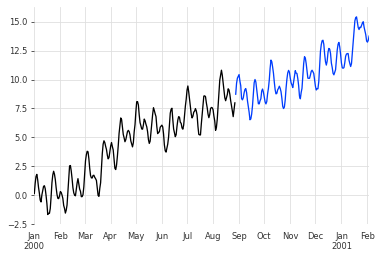

In [3]:
ts_length = 400
split_ratio = 0.6
sine_1_ts = tg.sine_timeseries(length=ts_length)
sine_2_ts = tg.sine_timeseries(length=ts_length, value_frequency=0.05)
linear_ts = tg.linear_timeseries(length=ts_length, end_value=5)
random_ts = tg.random_walk_timeseries(length=ts_length, std=0.2)

covariates = [sine_1_ts, linear_ts, random_ts]
covariates_past, covariates_future = zip(*[cov.split_after(split_ratio) for cov in covariates])
covariates_past_stacked, covariates_future_stacked = stack_ts_list(covariates_past), stack_ts_list(covariates_future)
covariates_stacked = stack_ts_list(covariates)

target = sine_1_ts + sine_2_ts + linear_ts + random_ts
target_past, target_future = target.split_after(split_ratio)

target_past.plot()
target_future.plot()

### No covariates, consuming output

In [4]:
model_tcn = TCNModel(
    input_chunk_length=50,
    output_chunk_length=1,
    n_epochs=100, 
    dropout=0, 
    dilation_base=2, 
    weight_norm=True,
    kernel_size=3,
    num_filters=2,
    nr_epochs_val_period=1,
    random_state=0
)

In [5]:
model_tcn.fit(series=target_past)

[2021-06-05 18:28:42,332] INFO | darts.models.torch_forecasting_model | Train dataset contains 190 samples.
[2021-06-05 18:28:42,332] INFO | darts.models.torch_forecasting_model | Train dataset contains 190 samples.
[2021-06-05 18:28:42,335] INFO | darts.models.tcn_model | Number of layers chosen: 4
[2021-06-05 18:28:42,335] INFO | darts.models.tcn_model | Number of layers chosen: 4


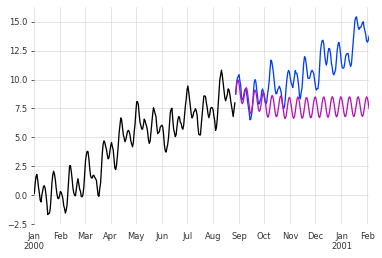

In [6]:
pred = model_tcn.predict(160)
target_past.plot()
target_future.plot()
pred.plot()

### Including future covariates, consuming output

In [7]:
model_tcn = TCNModel(
    input_chunk_length=50,
    output_chunk_length=1,
    n_epochs=100, 
    dropout=0, 
    dilation_base=2, 
    weight_norm=True,
    kernel_size=3,
    num_filters=2,
    nr_epochs_val_period=1,
    random_state=0
)

In [8]:
model_tcn.fit(series=target_past, covariates=covariates_past_stacked)

[2021-06-05 18:28:46,310] INFO | darts.models.torch_forecasting_model | Train dataset contains 190 samples.
[2021-06-05 18:28:46,310] INFO | darts.models.torch_forecasting_model | Train dataset contains 190 samples.
[2021-06-05 18:28:46,313] INFO | darts.models.tcn_model | Number of layers chosen: 4
[2021-06-05 18:28:46,313] INFO | darts.models.tcn_model | Number of layers chosen: 4


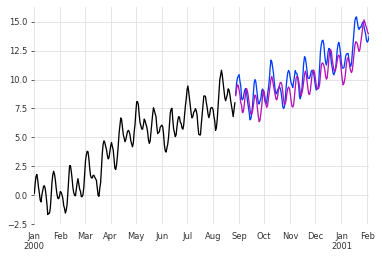

In [9]:
pred = model_tcn.predict(160, series=target_past, covariates=covariates_stacked, roll_size=1)
target_past.plot()
target_future.plot()
pred.plot()